# Kod för att visualisera resultaten

## 1. Läsa in datan

In [1]:
# Importera paket för att kunna köra hela koden
import pandas as pd

In [2]:
# Alla olika körningar
# Här får vi ändra beroende på hur output från klassifieringen ser ut
# Dessa två är bara påhittade dataset som de ser ut från DADA2, varje rad är en sekvens och sedan är kolumnerna olika taxonomiska nivåer
# Index är ett sekvens-ID som är samma i alla filer
# Om sekvensen inte kunnat klassifieras på någon nivå står det som NA

# Bara jämföra long och short reads
# long_reads = pd.read_csv('Long_reads.txt', sep=' ', names=['ID', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus'], index_col='ID')
# short_reads = pd.read_csv('Short_read.txt', sep=' ', names=['ID', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus'], index_col='ID')
# true_species = pd.read_csv('True_species.txt', sep=' ', names=['ID', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus'], index_col='ID')

long_reads = pd.read_csv('Test data/test_long_reads.txt', sep=',', index_col='ID')
short_reads = pd.read_csv('Test data/test_short_reads.txt', sep=',', index_col='ID')
true_species = pd.read_csv('Test data/test_true_taxonomy.txt', sep=',', index_col='ID')

In [3]:
# Titta på olika community structures
mock_community_structure = pd.read_csv('Test data/Mock_community_structure.txt', sep=' ', names=['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus'])
mock_community_1 = pd.read_csv('Test data/Mock_community_1.txt', sep=' ', names=['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus'])
mock_community_2 = pd.read_csv('Test data/Mock_community_2.txt', sep=' ', names=['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus'])

## 2. Titta på datan och beräkna statistik från den

### 2.1 Felklassifierade sekvenser

In [3]:
# Börja med att leta efter sekvenser som är felklassifierade

def find_misclassified(dataframe, correct_classification):
    '''Kollar om en klassifiering är korrekt eller inte.
    Input: Två dataset
    - Dataframe: Den föreslagna klassifieringen
    - Correct_classification: Den korrekta klassifieringen
    Output: Ett dataset liknande dataframe, men med två tillagda kolumner.
    - Correct: True/False beroende på om klassifieringen är korrekt eller inte
    - Incorrect at: Vilken taxonomisk nivå som är fel, om klassifieringen är inkorrekt'''

    # Skapa en kopia av inputdatan för att inte ändra orginalfilen
    dataframe_corrected = dataframe.copy(deep=True)

    # Loopa igenom alla sekvenser i inputdatan
    # Kolla om sekvensen med motsvarande ID i den korrekta klassifieringen är samma eller inte (True/False)
    # Lägg in det som en ny kolumn "Correct"
    for ID in dataframe.index:
        # Om det finns en NA-klassifiering
        # Kolla om allt fram till dess är korrekt --> Korrekt klassifiering
        # Om det innan är inkorrekt --> Inkorrekt klassifiering
        if dataframe[dataframe.index == ID].isnull().any().any():
            correct_maybe = dataframe[dataframe.index == ID].compare(correct_classification[correct_classification.index == ID], align_axis=0)
            highest_level = correct_maybe.columns[0]
            if dataframe_corrected.isnull().loc[dataframe_corrected.index == ID, highest_level].values[0]:
                same = True
            else:
                same = False
        else:
            same = dataframe[dataframe.index == ID].equals(correct_classification[correct_classification.index == ID])
        
        # Lägg till ifall klassifieringen är korrekt eller inte i datasetet
        dataframe_corrected.loc[dataframe.index == ID, 'Correct'] = same

        # Om klassifieringen inte är korrekt:
        # Lägg till på vilken högsta nivå den är fel i kolumnen "Incorrect at"
        if not same:
            incorrect_levels = dataframe[dataframe.index == ID].compare(correct_classification[correct_classification.index == ID], align_axis=0)
            dataframe_corrected.loc[short_reads.index == ID, 'Incorrect at'] = incorrect_levels.columns[0]
    
    return dataframe_corrected

In [4]:
short_corrected = find_misclassified(short_reads, true_species)
long_corrected = find_misclassified(long_reads, true_species)

### 2.2 Beräkna antalet korrekta/inkorrekta klassifieringar

In [5]:
# Från informationen om klassifieringarna och ifall de är korrekta eller inte vill vi beräkna:
# - Antalet korrekta klassifieringar på respektive nivå
# - Antalet sekvenser med sin (korrekta) lägsta klassifiering på olika nivåer (ex 10 sekvenser identifierades på artnivå, medan 17 bara på genusnivå)
# - Antalet inkorrekta klassifieringar på respektive högsta nivå (ex fel på family-nivå leder ju till fel genus också, så det ska bara räknas som family)
# Allt det ska sparas i dataframes för att kunna plottas

# Här sparas correct och incorrect i olika kolumner
def classification_stats(dataframe):
    '''Beräknar:
    - Antalet korrekta klassifieringar på respektive nivå
    - Antalet sekvenser med sin (korrekta) lägsta klassifiering på olika nivåer (ex 10 sekvenser identifierades på artnivå, medan 17 bara på genusnivå)
    - Antalet inkorrekta klassifieringar på respektive högsta nivå (ex fel family ger automatiskt fel genus, men ska endast rapporteras som fel på family-nivå)
    Input: En dataframe med sekvens-ID, klassifiering på olika nivåer, ifall klassifieringen är fel eller inte, samt vilken nivå den är fel på
    Output: Två dataframes
    - Antalet korrekta klassifieringar (totalt) på alla nivåer (oavsett om det är den högsta eller inte) (L*1)
    - Antalet korrekta och inkorrekta klassifieringar på olika nivåer där de är den lägsta (korrekta) vs högsta (inkorrekta) nivån (2L*1)
    '''

    # För alla korrekt klassifierade sekvenser:
    # Beräkna den totala antalet klassifieringar på respektive nivå
    correct_sequences = dataframe[dataframe['Correct'] == True]
    correct_class_all_levels = correct_sequences.iloc[:, 0:-2].notnull().sum()
    
    # Beräkna antalet sekvenser som har respektive nivå som sin lägsta klassifiering
    # Gör först en kopia för att ha det totala antalet klassifieringar på respektive nivå
    # Titta sedan på varje nivå förutom den lägsta, och substrahera antalet sekvenser som klassifierats på en lägre nivå
    class_levels = correct_class_all_levels.copy(deep=True)
    for level in range(len(correct_class_all_levels)-1):
        class_levels[level] -= correct_class_all_levels[level+1]
    
    # Gör om till dataframes, och transponera för att få rätt dimensioner
    correct_class_all_levels = correct_class_all_levels.to_frame()
    class_levels = class_levels.to_frame().transpose()

    # För alla inkorrekt klassifierade sekvenser:
    # Lägg till en (inkorrekt) kolumn för varje nivå med antalet sekvenser som har det som högsta felaktiga nivå
    incorrect_sequences = dataframe[dataframe['Correct'] == False]
    for level in class_levels.columns:
        name = level + '_incorrect'
        n = len(incorrect_sequences[incorrect_sequences['Incorrect at'] == level])
        class_levels[name] = n

    return correct_class_all_levels, class_levels

In [6]:
# Beräkna för respektive dataset
correct_all_levels_short, class_levels_short = classification_stats(short_corrected)
correct_all_levels_long, class_levels_long = classification_stats(long_corrected)

# Sammanställ dem till ett dataset 
samples = ['Long reads', 'Short reads']
all_levels = pd.concat([correct_all_levels_long, correct_all_levels_short], axis=1)
all_levels.columns = samples
class_levels = pd.concat([class_levels_long, class_levels_short])
class_levels.index = samples

# Skapa ytterligare ett dataset där siffrorna anges i procent
all_levels_ratio = all_levels.copy(deep=True)
class_levels_ratio = class_levels.copy(deep=True)
for sample in range(len(samples)):
    class_levels_ratio.iloc[sample,:] /= class_levels.iloc[sample,:].sum()
    all_levels_ratio.iloc[:, sample] /= class_levels.iloc[sample,:].sum()

### 2.3 Olika communities

In [8]:
# Vi vill titta igenom dataseten och hitta de unika raderna, alltså vilka organismer som har identifierats och hur många gånger

def find_organisms(dataframe):
    '''Tar en dataframe, hittar den lägsta taxonomiska nivån där det inte finns nullvärden, hittar de unika kolumnerna och räknar hur många gånger de förekommer
    Input: En dataframe (S*L) med sekvenser som rader, och taxonomisk tillhörighet på olika nivåer som kolumner
    Output: En dataframe med alla unika organismer på den lägsta gemensamma taxonomiska nivån, samt hur många gånger de finns'''
    # Skapa en kopia för att inte sabba datasetet
    # Titta i vilka celler det finns nullvärden
    dataframe_copy = dataframe.copy(deep=True)
    dataframe_null = dataframe_copy.isnull()

    # Gå igenom datasetet kolumn för kolumn, börja på den lägsta taxonomiska nivån
    # Om det finns ett nullvärde, droppa kolumnen
    for level in dataframe.columns[::-1]:
        if dataframe_null[level].any():
            dataframe_copy.drop(level, axis=1, inplace=True)
    
    # Ta bort alla kolumner utom den sista, som alltså är den lägsta taxonomiska nivån där alla organismer är identifierade
    dataframe_copy.drop(dataframe_copy.columns[:-1], axis=1, inplace=True)

    # Leta efter dubletter, dvs organismer som finns flera gånger
    # Räkna antalet dubletter, och lägg in i datasetet under "Count"
    # Lägg in namnen på organismerna som index
    dataframe_stats = dataframe_copy.groupby(dataframe_copy.columns.tolist()).size().reset_index(name='Count')
    dataframe_stats.index = dataframe_stats[dataframe_stats.columns[0]]
    dataframe_stats.drop(dataframe_stats.columns[0], axis=1, inplace=True)

    return dataframe_stats.transpose()

In [9]:
# Kör funktionen på alla dataset
mock_community_structure_organisms = find_organisms(mock_community_structure)
mock_community_1_organisms = find_organisms(mock_community_1)
mock_community_2_organisms = find_organisms(mock_community_2)

# Slå samman dataseten till ett stort, och definiera deras index som deras namn
communities = pd.concat([mock_community_structure_organisms, mock_community_1_organisms, mock_community_2_organisms])
communities.index = ['Mock community ideal', 'Mock 1', 'Mock 2']

# Skapa ytterligare ett dataset där siffrorna anges i procent
communities_ratio = communities.copy(deep=True)
for sample in range(len(samples)+1):
    communities_ratio.iloc[sample,:] /= communities.iloc[sample,:].sum()

## 3. Plotta resultaten

### 3.1 Statistisk på antalet klassifierade sekvenser på olika nivåer

In [7]:
import matplotlib.pyplot as plt

In [8]:
# Bestäm vilka olika färger som ska användas för respektive taxonomisk nivå, samt för de olika dataseten
# För korrekt klassifiering: Grönt
# För inkorrekt klassifiering: Rött
# För olika nivåer av klassifiering, olika ljus/mörk färg

# Antalet nivåer
n = len(class_levels.columns)/2

cmap_correct = plt.cm.get_cmap('Greens', n)
cmap_incorrect = plt.cm.get_cmap('Reds', n)

color_levels = {}
for i in range(int(n)):
    level_correct = class_levels.columns[i]
    color_levels[level_correct] = cmap_correct(i)

    level_incorrect = class_levels.columns[i+int(n)]
    color_levels[level_incorrect] = cmap_incorrect(i)

/var/folders/8y/zlyjdkl554bfq25qgv0m1v5r0000gn/T/ipykernel_2429/2448945740.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '20', '40', '60', '80', '100'])


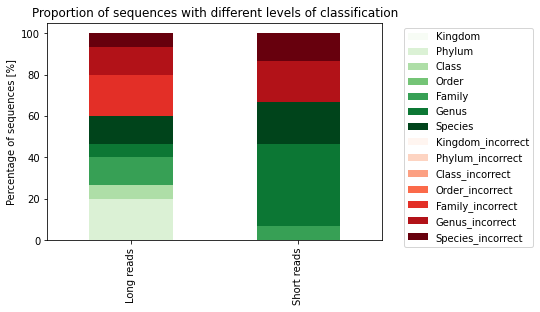

In [9]:
# Plotta resultaten i en stacked bar plot
fig, ax = plt.subplots()
class_levels_ratio.plot(kind='bar', stacked=True, color=color_levels, title='Proportion of sequences with different levels of classification', 
                        ylabel='Percentage of sequences [%]', ax=ax)
ax.set_yticklabels(['0', '20', '40', '60', '80', '100'])
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

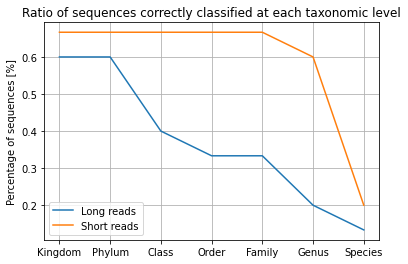

In [13]:
fig, ax = plt.subplots()
all_levels_ratio.plot(grid=True, title='Ratio of sequences correctly classified at each taxonomic level', ylabel='Percentage of sequences [%]', ax=ax)
plt.show()

### 3.2 Olika communities

/var/folders/8y/zlyjdkl554bfq25qgv0m1v5r0000gn/T/ipykernel_1808/2351789441.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '20', '40', '60', '80', '100'])


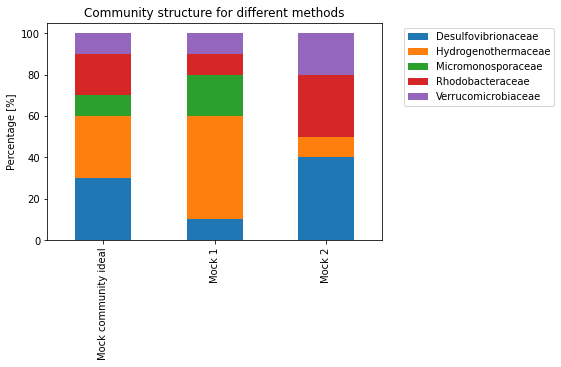

In [14]:
# Plotta strukturen på olika communities i förhållande till varandra
fig, ax = plt.subplots()
communities_ratio.plot(kind='bar', stacked=True, title='Community structure for different methods', ylabel='Percentage [%]', ax=ax)
ax.set_yticklabels(['0', '20', '40', '60', '80', '100'])
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()